In [1]:
# import basic packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# import train test
from sklearn.model_selection import train_test_split

### Prediction Task: Will an applicant be approved for a home purchase conventional mortgage?

### Data Processing

In [2]:
# read in all mortgage data from 2017
'''
I could use data from more years as well, just that the data is extremely large and would take up a good amount of 
space to run. Given that our final algorithm will be slow as is, I think limiting the amount of data we train with
would make things easier overall (especially since we aren't really looking for a perfect model). Lmk what y'all 
think!
''' 
mort_df = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')

/var/folders/gp/89jvsfhd6zn10r7krkzw4l7w0000gn/T/ipykernel_27480/3640280804.py:8: DtypeWarning: Columns (34,36,38,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  mort_df = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')


In [3]:
# dropping columns with only invalid values
mort_df = mort_df.dropna(axis = 1, how = 'all')

In [4]:
mort_df.shape

(14285496, 74)

In [5]:
mort_df.describe()

,as_of_year,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,msamd,...,denial_reason_3,rate_spread,hoepa_status,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units
count,14285496.0,1.428550e+07,1.428550e+07,1.428550e+07,1.428550e+07,1.428550e+07,1.428046e+07,1.428550e+07,1.428550e+07,1.249445e+07,...,49338.000000,493273.000000,1.428550e+07,1.428550e+07,1.400119e+07,1.400114e+07,1.400119e+07,1.400119e+07,1.400114e+07,1.400114e+07
mean,2017.0,6.809450e+00,1.439923e+00,1.044156e+00,1.845050e+00,1.102287e+00,2.480836e+02,2.796495e+00,2.627451e+00,3.045841e+04,...,5.053833,2.473063,1.999748e+00,1.522989e+00,5.720964e+03,3.273188e+01,7.083347e+04,1.130236e+02,1.465340e+03,2.004188e+03
std,0.0,2.122487e+00,7.467081e-01,2.224088e-01,9.484542e-01,3.172205e-01,1.481113e+03,4.790466e-01,1.931120e+00,1.132808e+04,...,2.680472,1.441981,1.587924e-02,1.087268e+00,3.170171e+03,2.618514e+01,1.494926e+04,4.088793e+01,8.862358e+02,1.099152e+03
min,2017.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.014000e+04,...,1.000000,1.500000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.580000e+04,0.000000e+00,0.000000e+00,0.000000e+00
25%,2017.0,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.120000e+02,3.000000e+00,1.000000e+00,1.966000e+04,...,3.000000,1.660000,2.000000e+00,1.000000e+00,3.853000e+03,1.173000e+01,6.160000e+04,8.649000e+01,9.260000e+02,1.341000e+03
50%,2017.0,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.850000e+02,3.000000e+00,1.000000e+00,3.278000e+04,...,5.000000,1.900000,2.000000e+00,1.000000e+00,5.161000e+03,2.485000e+01,6.810000e+04,1.077000e+02,1.321000e+03,1.817000e+03
75%,2017.0,9.000000e+00,2.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,2.900000e+02,3.000000e+00,4.000000e+00,4.014000e+04,...,7.000000,2.490000,2.000000e+00,1.000000e+00,6.784000e+03,4.782000e+01,7.750000e+04,1.331300e+02,1.808000e+03,2.422000e+03
max,2017.0,9.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.400000e+06,3.000000e+00,8.000000e+00,4.978000e+04,...,9.000000,99.990000,2.000000e+00,4.000000e+00,5.381200e+04,1.000000e+02,1.315000e+05,5.074700e+02,1.952900e+04,2.539100e+04


In [6]:
# Removing instances of incomplete/withdrawn and preapproval only applications
inval_obs = [i for i, j in mort_df['action_taken'].items() if j not in [4, 5, 7, 8]]
prim_df = mort_df.iloc[inval_obs]

# Limit to only conventional loans for home purchases
prim_df = prim_df[(prim_df['loan_purpose'] == 1) & (prim_df['loan_type'] == 1)]

# Limit demographic data scope to only primary applicants; dropping unnecessary columns
prim_df = prim_df[['respondent_id', 'action_taken_name', 'action_taken', 'state_name', 
                   'state_abbr', 'applicant_ethnicity_name', 'applicant_ethnicity', 
                   'applicant_race_name_1', 'applicant_race_1', 'applicant_race_name_2', 
                   'applicant_race_2', 'applicant_sex_name', 'applicant_sex', 
                   'applicant_income_000s']]

### EDA

Text(0.5, 1.0, 'Proportion of Actions Taken')

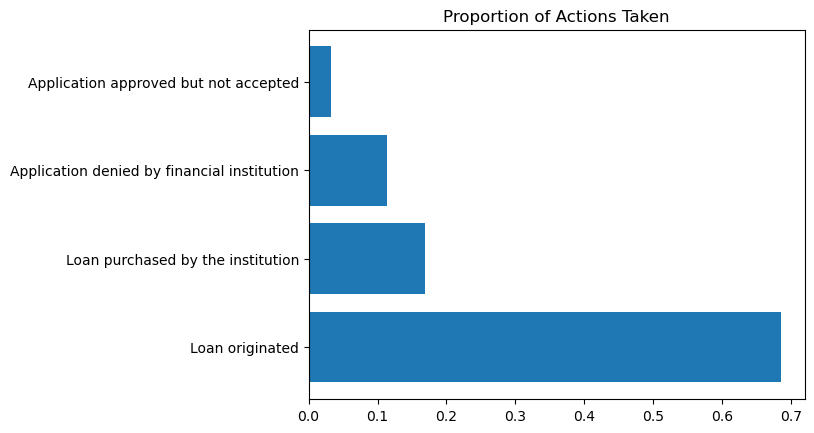

In [7]:
# Action Taken
action_prop = prim_df['action_taken_name'].value_counts(normalize = True)

plt.barh(action_prop.index, action_prop)
plt.title('Proportion of Actions Taken')

Text(0.5, 1.0, 'Proportion of Race')

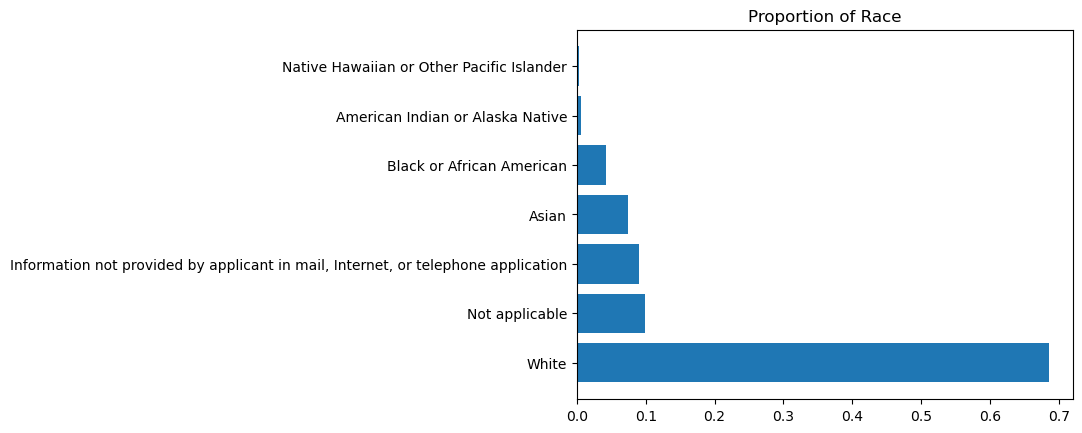

In [8]:
# Proportion of Race
race_prop = prim_df['applicant_race_name_1'].value_counts(normalize = True)

plt.barh(race_prop.index, race_prop)
plt.title('Proportion of Race')

Text(0.5, 1.0, 'Proportion of Sex')

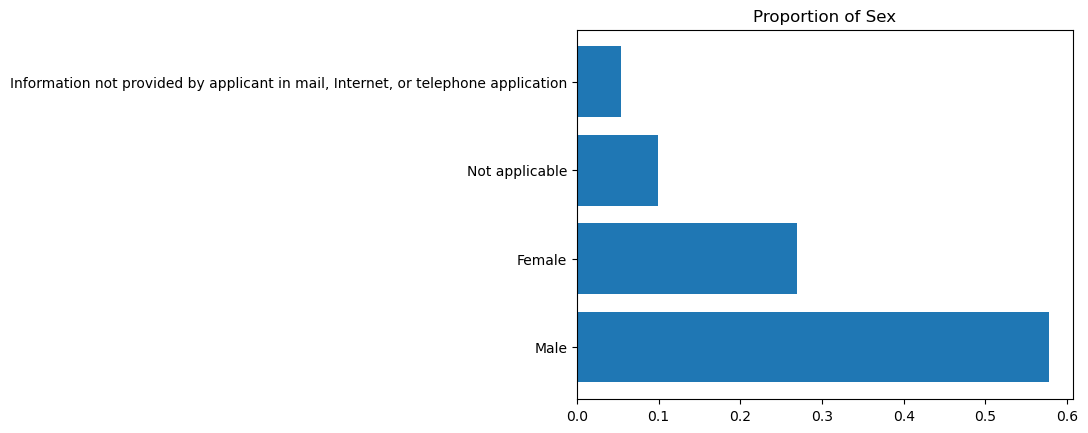

In [9]:
# Proportion of Sex
sex_prop = prim_df['applicant_sex_name'].value_counts(normalize = True)

plt.barh(sex_prop.index, sex_prop)
plt.title('Proportion of Sex')

### Model Building